In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# 1) Load data
base_dir = Path.cwd().parent           # /Users/…/prob-extrapolation-classify-accuracy
Pneumonia_dir = base_dir / "prob-extrapolation-classify-accuracy/admissions.csv"
admission_csv_path = base_dir / Pneumonia_dir
df = pd.read_csv(admission_csv_path, parse_dates=["admittime","dischtime","edregtime","edouttime","deathtime"])
# 2) Create features & target
df["ed_duration"] = (df.edouttime - df.edregtime).dt.total_seconds() / 3600.0  # hours in ED
# Drop rows missing target
df = df.dropna(subset=["hospital_expire_flag"])
y = df["hospital_expire_flag"].astype(int)

# Choose predictors
cat_cols = ["admission_type","admission_location","discharge_location",
            "insurance","language","marital_status","race"]
num_cols = ["ed_duration"]

X = df[cat_cols + num_cols]

# 3) Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# after your train/test split:
N_train = len(X_train_full)  # ≈176
min_size = 10
num_points = 4

# pick 4 sizes geometrically spaced in [min_size, N_train]
raw_sizes = np.geomspace(min_size, N_train, num=num_points)
# round + unique + ensure ≥ 2
subset_sizes = sorted({max(2, int(round(s))) for s in raw_sizes})

print("Subset sizes:", subset_sizes)
# e.g. [10, 19, 36, 176]

preprocessor = ColumnTransformer([
    ("num",   Pipeline([("imp", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler())]),
               num_cols),
    ("cat",   Pipeline([("imp", OneHotEncoder(handle_unknown="ignore"))]),
               cat_cols),
])

model = Pipeline([
    ("prep", preprocessor),
    ("clf",  LogisticRegression(solver="lbfgs", max_iter=200))
])

def eval_at_size(train_size):
    # If they want the entire set, just use it directly
    if train_size >= N_train:
        X_sub = X_train_full
        y_sub = y_train_full
    else:
        # Otherwise compute a fraction < 1.0
        frac = train_size / N_train
        X_sub, _, y_sub, _ = train_test_split(
            X_train_full, y_train_full,
            train_size=frac,
            random_state=0,
            stratify=y_train_full
        )
    # Train and evaluate
    model.fit(X_sub, y_sub)
    probs = model.predict_proba(X_test)[:,1]
    return {
        "train_size": len(X_sub),
        "auroc": roc_auc_score(y_test, probs)
    }


# run the loop
results = [eval_at_size(s) for s in subset_sizes]
df = pd.DataFrame(results)
print(df)


Subset sizes: [10, 28, 79, 220]
   train_size     auroc
0          10  0.769231
1          27  0.833333
2          79  0.980769
3         220  1.000000


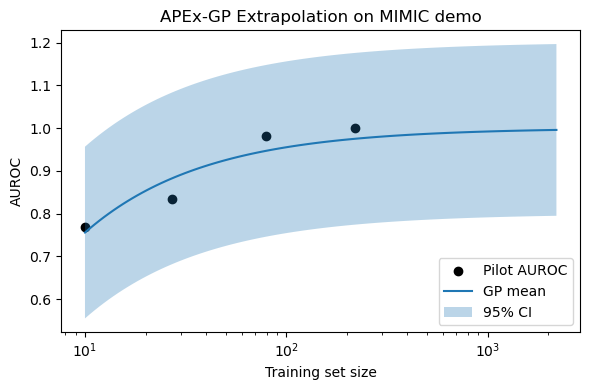

In [12]:
import torch
import matplotlib.pyplot as plt
import gpytorch
import sys
from pathlib import Path
from gpytorch.constraints import GreaterThan


# Add the directory containing the models module to the Python path
sys.path.append(str(Path.cwd().parent / 'src'))  # Adjust the path to the correct location of the 'src' directory

from src.initial_models import GPPowerLaw  # Adjust to wherever you defined it
# 1) Convert pilot curve to torch tensors
X = df["train_size"].values         # e.g. [10, 19, 36, 176]
y = df["auroc"].values  
train_x = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # shape [n,1]
train_y = torch.tensor(y, dtype=torch.float32)

# 2) Instantiate likelihood + model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Initialize noise variance to 1e-2 (or whatever makes sense for your scale)
likelihood.noise_covar.initialize(noise=1e-2)

# Constrain the raw noise parameter so noise ≥ 1e-6 at every step
likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-6))
likelihood.noise_covar.raw_noise.requires_grad_(False)
model = GPPowerLaw(train_x, train_y, likelihood, with_priors=False)

# 3) Train (MAP / MLE)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(200):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# 4) Switch to eval + extrapolate
model.eval()
likelihood.eval()
# define a log‑spaced grid up to e.g. 10× your max pilot size
# Ensure X.min() is not zero to avoid division by zero in log10
# Ensure X.min() is not zero to avoid division by zero in log10
test_sizes = np.logspace(np.log10(X.min()), np.log10(X.max()*10), 100)
test_x = torch.tensor(test_sizes, dtype=torch.float32).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))
    mean = preds.mean.numpy()
    lower, upper = preds.confidence_region()
    lower = lower.numpy()
    upper = upper.numpy()

# 5) Plot your pilot points + extrapolation
plt.figure(figsize=(6,4))
plt.scatter(X, y, label="Pilot AUROC", color="k")
plt.plot(test_sizes, mean, label="GP mean")
plt.fill_between(test_sizes, lower, upper, alpha=0.3, label="95% CI")
plt.xscale("log")
plt.xlabel("Training set size")
plt.ylabel("AUROC")
plt.legend()
plt.title("APEx‑GP Extrapolation on MIMIC demo")
plt.tight_layout()
plt.show()
